In [1]:
import pandas as pd
import numpy as np
import ast

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn, optim
from torchvision import datasets, utils, models
# from torchinfo import summary
import torch.nn.functional as F
from torchvision.transforms import v2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import altair as alt
alt.data_transformers.enable("vegafusion")

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import multiprocessing

In [2]:
# Change csv name as needed
labels_extended = pd.read_csv('data/selected_gene_df.csv')
clean_possible_genes = labels_extended.columns.to_list()[7:]
num_labels = len(clean_possible_genes)

In [3]:
train_df, test_df = train_test_split(labels_extended, train_size=0.85, random_state=123)
test_df.set_index('index', inplace=True)
print(f'Shape of trainset: {train_df.shape}')
print(f'Shape of testset: {test_df.shape}')

Shape of trainset: (31083, 27)
Shape of testset: (5486, 26)


In [4]:
class PythonGeneDataset(Dataset):
    def __init__(self, labels_df, img_dir, indices=None, transform=None):
        self.labels_df = labels_df
        if indices is not None:
            self.labels_df = self.labels_df.iloc[indices]
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.labels_df.iloc[idx, 0]}.png")
        image = Image.open(img_name)
        # Parse labels here based on your CSV structure and required format
        labels = torch.tensor(self.labels_df.iloc[idx, 7:].astype('float32').values)
        
        if self.transform:
            image = self.transform(image)

        return image, labels


In [5]:
IMAGE_SIZE = 512

new_layers = nn.Sequential(
    nn.Linear(1920, 1000),  # Reduce dimension from 1024 to 500
    nn.BatchNorm1d(1000),   # Normalize the activations from the previous layer
    nn.ReLU(),             # Non-linear activation function
    nn.Dropout(0.5),       # Dropout for regularization (50% probability)
    nn.Linear(1000, num_labels)  # Final layer for class predictions
)

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True), # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

full_dataset = PythonGeneDataset(labels_df=train_df, img_dir='data/img/', transform=transform)

# Split dataset
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
valid_size = total_size - train_size
train_indices, valid_indices = torch.utils.data.random_split(np.arange(total_size), [train_size, valid_size])

# Create train and validation datasets
train_dataset = Subset(full_dataset, train_indices)
valid_dataset = Subset(full_dataset, valid_indices)

# Initialize DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=multiprocessing.cpu_count())
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=multiprocessing.cpu_count())

## Predictions

In [6]:
densenet = models.densenet201(weights='DenseNet201_Weights.DEFAULT')
densenet.classifier = new_layers
optimizer = torch.optim.Adam(densenet.parameters(), lr=0.001)

checkpoint = torch.load(f'model/model_v8_epoch9.pt')
densenet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['train_loss']
valid_loss = checkpoint['valid_loss']

densenet.eval()

# If using GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
densenet.to(device)
print(f"{train_loss}, {valid_loss}")

cuda
0.004188287051583798, 0.007725452748228398


True Morphs: ['Pinstripe', 'Enchi', 'Super Pastel']


,predictions
Super Pastel,0.935707
Pinstripe,0.893939
Enchi,0.624616


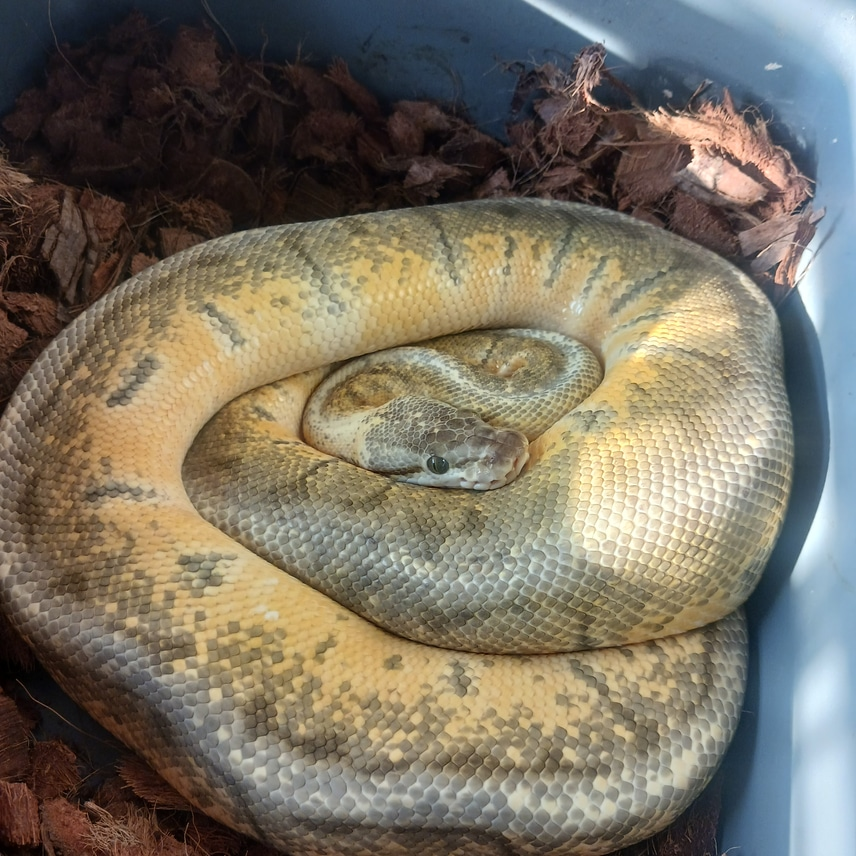

In [97]:
# Prediction from Test set
img_code = np.random.choice(test_df.index)
img = Image.open(f'data/img/{img_code}.png')
input_img = transform(img)
input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)


with torch.no_grad():
    output = densenet(input_img)

predicted_probs = torch.sigmoid(output).to('cpu')
prediction = pd.DataFrame(predicted_probs, index=['predictions'],
                          columns=clean_possible_genes).T.sort_values(by=['predictions'], ascending=False)

print(f'True Morphs: {test_df.loc[img_code, "genes"]}')
display(prediction.query('predictions > 0.5'))
img

Predictions for all the pictures for a listing

In [8]:
# Does not work because of random train test split

# img_code = np.random.choice(test_df.index)
# img_code_parent = img_code.split("-")[0]
# test_df.index[test_df.index.astype(str).str.contains(fr'^{img_code_parent}-')].to_list()

In [9]:
# Prediction on the whole test set
test_df_pred = {}

for img_code in test_df.index:
    img = Image.open(f'data/img/{img_code}.png')
    input_img = transform(img)
    input_img = input_img.unsqueeze(0)
    input_img = input_img.to(device)

    with torch.no_grad():
        output = densenet(input_img)

    predicted_probs = torch.sigmoid(output).to('cpu')
    test_df_pred[img_code] = predicted_probs

In [10]:
pred_df = {key: val.numpy().flatten() for key, val in test_df_pred.items()}
pred_df = pd.DataFrame.from_dict(pred_df, orient='index', columns=clean_possible_genes)
pred_df_round = pred_df.round()

In [11]:
def count_matching_elements(list1, list2):
    count = sum(1 for x, y in zip(list1, list2) if x == y)
    return count

count_matching_elements(pred_df_round.loc['12861-1'].to_list(), test_df.loc['12861-1'][6:].to_list())

19

In [12]:
result = []
for idx in pred_df_round.index:
    pred = count_matching_elements(pred_df_round.loc[idx].to_list(), test_df.loc[idx][6:].to_list())
    result.append(pred)
    
for n in range(20, -1, -1):
    print(f'Prediction with {20-n} mistake: {result.count(n) / len(result):.3f}')

Prediction with 0 mistake: 0.532
Prediction with 1 mistake: 0.268
Prediction with 2 mistake: 0.139
Prediction with 3 mistake: 0.046
Prediction with 4 mistake: 0.009
Prediction with 5 mistake: 0.005
Prediction with 6 mistake: 0.000
Prediction with 7 mistake: 0.000
Prediction with 8 mistake: 0.000
Prediction with 9 mistake: 0.000
Prediction with 10 mistake: 0.000
Prediction with 11 mistake: 0.000
Prediction with 12 mistake: 0.000
Prediction with 13 mistake: 0.000
Prediction with 14 mistake: 0.000
Prediction with 15 mistake: 0.000
Prediction with 16 mistake: 0.000
Prediction with 17 mistake: 0.000
Prediction with 18 mistake: 0.000
Prediction with 19 mistake: 0.000
Prediction with 20 mistake: 0.000
